In [2]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ------ --------------------------------- 0.5/3.0 MB 5.6 MB/s eta 0:00:01
     --------------------------- ------------ 2.1/3.0 MB 6.2 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 6.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.9-py3-none-any.whl size=139095 sha256=a22fe929ac45d4732a2a4c3100154b804b4f305a6faadd664f1b2e750f702428
  Stored in directory: c:\users\vinay\appdata\local\pip\cache\wheels\43\ef\2d\2c51d496bf084945ffdf838b4cc8767b8ba1cc20eb41588831
Successfully built peewee


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Load Reliance stock data (Last 5 years)
data = yf.download("RELIANCE.NS", start="2019-01-01", end="2024-03-01")
data = data[['Close']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

Price,Close
Ticker,RELIANCE.NS
Date,
2019-01-01,493.702728
2019-01-02,487.272736
2019-01-03,481.261108
2019-01-04,483.859528
2019-01-07,486.546082


In [6]:
# Create Moving Averages
data['SMA_50'] = data['Close'].rolling(50).mean()
data['SMA_200'] = data['Close'].rolling(200).mean()

In [7]:
# Create Lag Features
for i in range(1, 6):
    data[f'Close_Lag_{i}'] = data['Close'].shift(i)

In [8]:
# Drop NaN values
data.dropna(inplace=True)

In [9]:
X = data.drop('Close', axis=1)
y = data['Close']

In [10]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [12]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

C:\Users\vinay\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [13]:
future_dates = pd.date_range(start="2024-03-02", periods=365, freq='D')
future_data = pd.DataFrame(index=future_dates)

In [14]:
# Use the last known data for future feature generation
last_known_data = data.iloc[-5:].copy()

In [18]:
# Generate future predictions iteratively
for i in range(365):
    input_features = last_known_data.iloc[-1].drop('Close').values.reshape(1, -1)
    pred_price = rf_model.predict(input_features)[0]
    
# Append predicted value to dataset
    new_row = pd.Series(index=last_known_data.columns)
    new_row['Close'] = pred_price
    for j in range(1, 6):
        new_row[f'Close_Lag_{j}'] = last_known_data.iloc[-1][f'Close_Lag_{j-1}'] if j > 1 else pred_price
    
# Append to dataset
    last_known_data = pd.concat([last_known_data, new_row.to_frame().T], ignore_index=True)

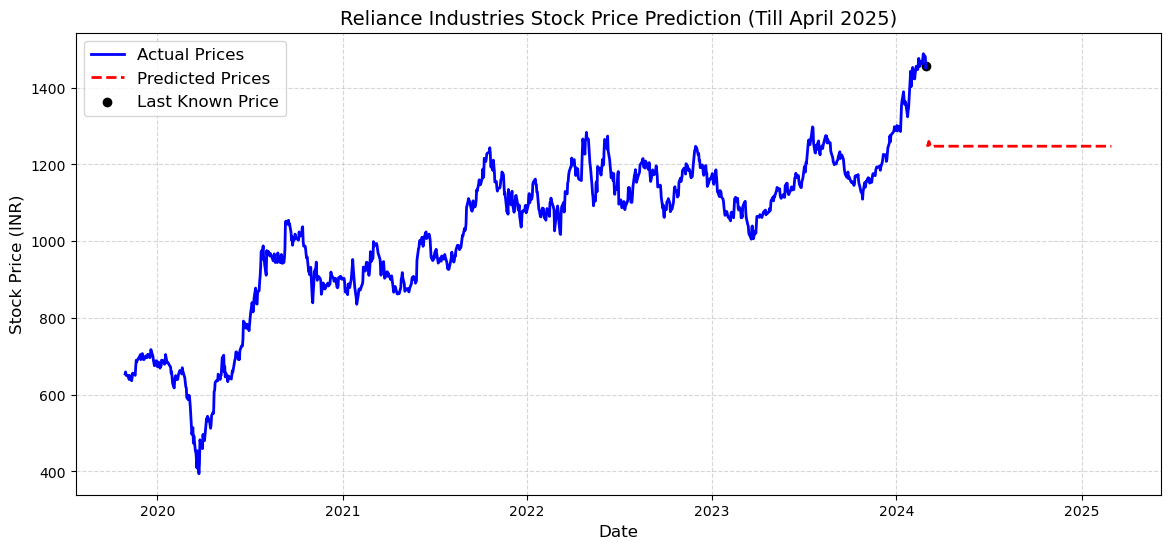

In [28]:
# Plot Actual vs Predicted Prices
plt.figure(figsize=(14, 6))  # Bigger size for clarity

# Actual Prices (Blue)
plt.plot(data.index, data['Close'], label="Actual Prices", color='blue', linewidth=2)

# Predicted Prices (Red Dotted Line)
plt.plot(future_dates, last_known_data['Close'][-365:], label="Predicted Prices", 
         color='red', linestyle="dashed", linewidth=2)


plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price (INR)", fontsize=12)
plt.title("Reliance Industries Stock Price Prediction (Till April 2025)", fontsize=14)

# Grid for Better Visibility
plt.grid(True, linestyle="--", alpha=0.5)

# Add a Marker for Last Known Price
plt.scatter(data.index[-1], data['Close'].iloc[-1], color='black', marker='o', label="Last Known Price")

# Show Legend Clearly
plt.legend(loc="upper left", fontsize=12)

# Show the Plot
plt.show()

C:\Users\vinay\AppData\Local\Temp\ipykernel_26628\2852975500.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_value = float(last_known_data['Close'].iloc[-365 + i])  # Convert to float
C:\Users\vinay\AppData\Local\Temp\ipykernel_26628\2852975500.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_price = float(last_known_data['Close'].iloc[-1])  # Last predicted price


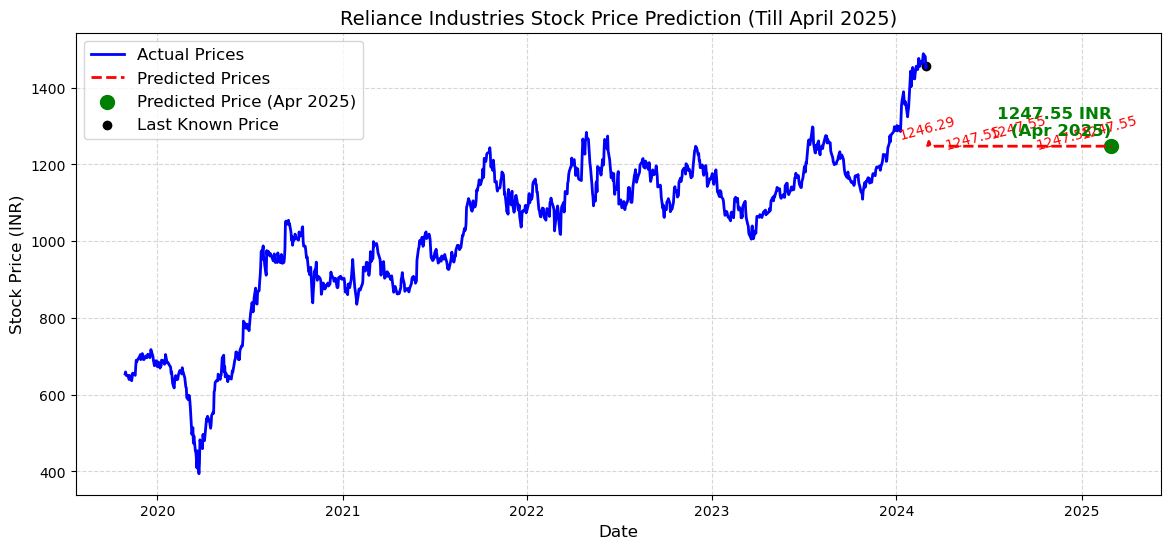

In [33]:
# Plot Figure
plt.figure(figsize=(14, 6))

# Actual Prices (Blue Line)
plt.plot(data.index, data['Close'], label="Actual Prices", color='blue', linewidth=2)

# Predicted Prices (Red Dashed Line)
plt.plot(future_dates, last_known_data['Close'][-365:], label="Predicted Prices", 
         color='red', linestyle="dashed", linewidth=2)

# Highlight Specific Predicted Points with Values (Every ~90 Days)
for i in range(0, 365, 90):  # Adjusting spacing to reduce overlap
    predicted_value = float(last_known_data['Close'].iloc[-365 + i])  # Convert to float
    
    # Alternate text position (up/down) to avoid clutter
    y_offset = 12 if i % 180 == 0 else -15  
    ha = 'center'

    plt.text(future_dates[i], predicted_value + y_offset, f"{predicted_value:.2f}", 
             fontsize=10, color='red', verticalalignment='bottom', horizontalalignment=ha, rotation=15)

# Add Last Predicted Price (April 2025)
final_price = float(last_known_data['Close'].iloc[-1])  # Last predicted price
final_date = future_dates[-1]  # Last predicted date

plt.scatter(final_date, final_price, color='green', marker='o', s=100, label="Predicted Price (Apr 2025)")  # Green dot
plt.text(final_date, final_price + 20, f"{final_price:.2f} INR\n(Apr 2025)", 
         fontsize=12, color='green', verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

# Labels and Title
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price (INR)", fontsize=12)
plt.title("Reliance Industries Stock Price Prediction (Till April 2025)", fontsize=14)

# Grid for Better Visibility
plt.grid(True, linestyle="--", alpha=0.5)

# Marker for Last Known Price
plt.scatter(data.index[-1], data['Close'].iloc[-1], color='black', marker='o', label="Last Known Price")

# Show Legend
plt.legend(loc="upper left", fontsize=12)

# Display the Plot
plt.show()